In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Specify data paths
dataset = 'out/gestures.csv'
model_save_path = 'models/classifier.hdf5'
tflite_save_path = 'models/lite.hdf5'

# Load Dataset

In [3]:
data = pd.read_csv(dataset, header=None) 

y = data.iloc[:, 0]
X = data.iloc[: , 1:]

y.value_counts()

machedici      447
one_up         414
hand_closed    410
random         407
two_up         387
hand_open      339
victory        310
hang_in        310
call           284
ok             215
Name: 0, dtype: int64

In [4]:
classes = y.unique()
classes = {classes[i]: i for i in range(len(classes))}

y = y.map(classes)

X = X.to_numpy().astype(np.float32)
y = y.to_numpy().astype(np.float32)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_SEED)

# # y_train = y_train.reshape(len(y_train),1)
# # y_test = y_test.reshape(len(y_test),1)
# classes = len(np.unique(y))

10

In [15]:
n_input = X_train.shape[1]
n_output = len(np.unique(y))

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((n_input, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(n_output, activation='softmax')
])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-23 19:28:06.366911: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-23 19:28:06.367954: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1

In [17]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback],
    verbose=1
)

2022-07-23 19:28:17.386213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-23 19:28:17.389960: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000


2022-07-23 19:28:17.683942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


42/42 [==============================] - 2s 21ms/step - loss: 2.2946 - accuracy: 0.1151 - val_loss: 2.2866 - val_accuracy: 0.1169


2022-07-23 19:28:19.657185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 2.28659, saving model to models/classifier.hdf5
Epoch 2/1000
42/42 [==============================] - 0s 11ms/step - loss: 2.2650 - accuracy: 0.1431 - val_loss: 2.2736 - val_accuracy: 0.1169

Epoch 00002: val_loss improved from 2.28659 to 2.27364, saving model to models/classifier.hdf5
Epoch 3/1000
42/42 [==============================] - 1s 12ms/step - loss: 2.2382 - accuracy: 0.1927 - val_loss: 2.2565 - val_accuracy: 0.1169

Epoch 00003: val_loss improved from 2.27364 to 2.25648, saving model to models/classifier.hdf5
Epoch 4/1000
42/42 [==============================] - 0s 12ms/step - loss: 2.2024 - accuracy: 0.2051 - val_loss: 2.1896 - val_accuracy: 0.2043

Epoch 00004: val_loss improved from 2.25648 to 2.18961, saving model to models/classifier.hdf5
Epoch 5/1000
42/42 [==============================] - 0s 12ms/step - loss: 2.1352 - accuracy: 0.2373 - val_loss: 2.0937 - val_accuracy: 0.2157

Epoch 00005: val_loss improved from 2.18961 to 

In [18]:
model = tf.keras.models.load_model(model_save_path)
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

14/14 [==============================] - 0s 8ms/step - loss: 0.2361 - accuracy: 0.9183


2022-07-23 19:36:50.262365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [19]:
model = tf.keras.models.load_model(model_save_path)

In [20]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

2022-07-23 19:36:56.087189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[1.2063740e-04 5.2789921e-01 5.2896069e-14 1.7285601e-20 1.2003147e-10
 4.7176611e-01 5.0331753e-11 7.4186154e-13 1.4824805e-20 2.1403500e-04]
1


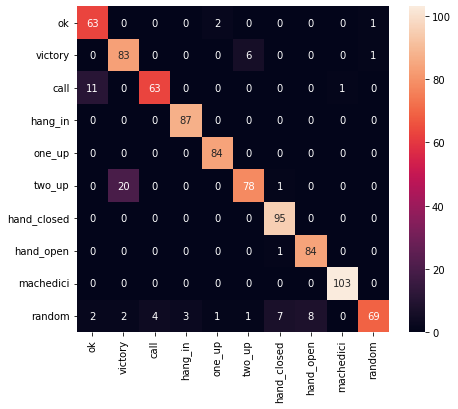

Classification Report
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89        66
         1.0       0.79      0.92      0.85        90
         2.0       0.94      0.84      0.89        75
         3.0       0.97      1.00      0.98        87
         4.0       0.97      1.00      0.98        84
         5.0       0.92      0.79      0.85        99
         6.0       0.91      1.00      0.95        95
         7.0       0.91      0.99      0.95        85
         8.0       0.99      1.00      1.00       103
         9.0       0.97      0.71      0.82        97

    accuracy                           0.92       881
   macro avg       0.92      0.92      0.92       881
weighted avg       0.92      0.92      0.92       881



In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, dict_keys=None, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    if dict_keys:
        labels = [dict_keys[x] for x in labels]

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred, {v: k for k, v in classes.items()})

In [63]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2022-07-23 20:27:36.628938: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/3w/bsb667zn42gdhbqq3z8ptmgw0000gn/T/tmpt4s7ox_2/assets


2022-07-23 20:27:37.072456: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-07-23 20:27:37.076387: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-07-23 20:27:37.080227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-23 20:27:37.080364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-23 20:27:37.130244: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1144] Optimization results for grappler item: graph_to_optimize
  function_optimizer: funct

7840

Inference test

In [64]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [65]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 658 µs, sys: 1.1 ms, total: 1.76 ms
Wall time: 988 µs


In [66]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.3759111e-04 5.1659691e-01 6.2522836e-14 1.4260615e-20 1.3898015e-10
 4.8304182e-01 4.5237612e-11 6.0631383e-13 1.6117900e-20 2.2362331e-04]
1
